In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Параметры
batch_size = 32
num_classes = 10  # Для Moving MNIST 10 классов (0-9)

# Загрузка датасета Moving MNIST
class MovingMNIST(datasets.VisionDataset):
    def __init__(self, root, train=True, transform=None):
        super(MovingMNIST, self).__init__(root, transform=transform)
        mnist = datasets.MNIST(root=root, train=train, download=True)
        self.data = mnist.data.unsqueeze(1).float() / 255.0  # Добавляем канал (1, H, W)
        self.labels = mnist.targets

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        # Создаем два канала путем дублирования изображения
        two_channel_image = torch.cat([image, image], dim=0)  # (2, H, W)

        if self.transform:
            two_channel_image = self.transform(two_channel_image)

        return two_channel_image, label

    def __len__(self):
        return len(self.data)

# Трансформации
transform = transforms.Compose([
    transforms.Resize((28, 28)),
])

# Загрузка данных
train_dataset = MovingMNIST(root='./data', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Определение модели
class VideoClassifier(nn.Module):
    def __init__(self):
        super(VideoClassifier, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Вычислим размер выхода после сверток
        self.fc1_input_size = 32 * 7 * 7  # После двух пулингов (28 -> 14 -> 7)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 16, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 32, 7, 7)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = VideoClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Обучение завершено!')

Epoch [1/5], Loss: 0.1582
Epoch [2/5], Loss: 0.0520
Epoch [3/5], Loss: 0.0354
Epoch [4/5], Loss: 0.0257
Epoch [5/5], Loss: 0.0201
Обучение завершено!


In [24]:
import matplotlib.pyplot as plt

def visualize_input_data(inputs, labels, num_samples=5):
    """
    Визуализация входных данных.

    Args:
        inputs (torch.Tensor): Тензор входных данных размером (batch_size, channels, height, width).
        labels (torch.Tensor): Тензор меток размером (batch_size,).
        num_samples (int): Количество изображений для отображения.
    """
    # Переводим тензоры на CPU и преобразуем в numpy
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()

    # Определяем количество каналов
    num_channels = inputs.shape[1]

    # Создаем подграфики для отображения
    fig, axes = plt.subplots(num_samples, num_channels, figsize=(10, 2 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # Для корректной работы с одним образцом

    for i in range(num_samples):
        for j in range(num_channels):
            ax = axes[i, j]
            ax.imshow(inputs[i, j], cmap='gray')  # Отображаем каждый канал в градациях серого
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Label: {labels[i]}")  # Добавляем метку к первому каналу

    plt.tight_layout()
    plt.show()

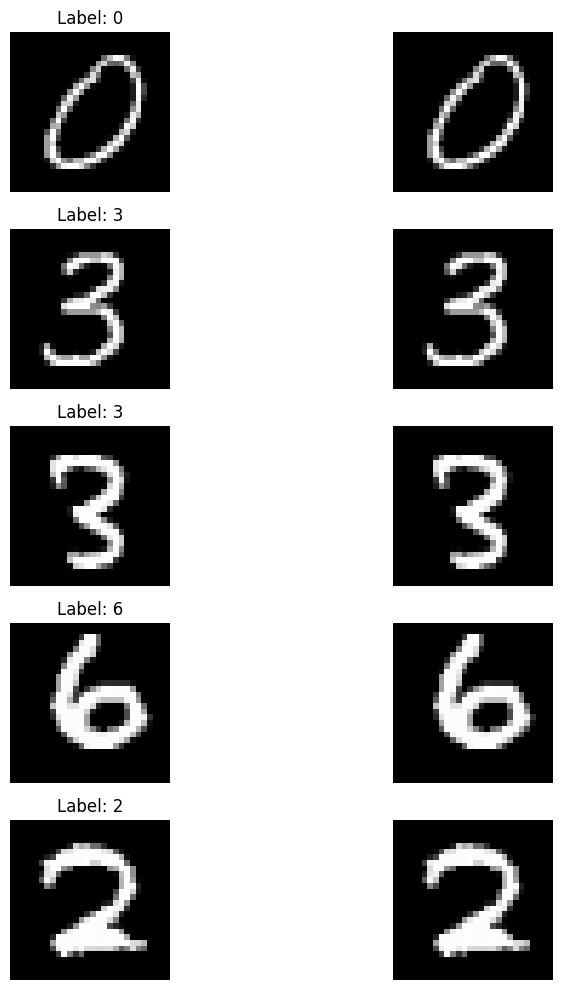

In [25]:
# Внутри цикла обучения
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Визуализация первых нескольких батчей
    visualize_input_data(inputs[:5], labels[:5])  # Показываем 5 изображений
    break  # Прерываем цикл после первой визуализации